In [0]:
# !unzip -uq '/content/drive/My Drive/one shot learning/train.zip' -d '/content'
# !unzip -uq '/content/drive/My Drive/one shot learning/test.zip' -d '/content'

In [0]:
import numpy as np
import cv2
from skimage.io import imread
import os
from tqdm import tqdm
import pickle
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dense,Flatten,Concatenate,Lambda,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import time

In [0]:
def load_data(path):
  n=0
  lang_dict={}
  for i in sorted(os.listdir(path)):
    lang_dict[i]=[n,n+len(os.listdir(os.path.join(path,i)))-1]
    n=n+len(os.listdir(os.path.join(path,i)))
  
  x=None
  y=[]
  c=0
  for i in tqdm(sorted(os.listdir(path))):
    for j in sorted(os.listdir(os.path.join(path,i))):
      data=[]
      for k in sorted(os.listdir(os.path.join(os.path.join(path,i),j))):
        img_path=os.path.join(os.path.join(os.path.join(path,i),j),k)
        data.append(imread(img_path))
        if(c==0):
          y.append(c)
        else:
          y=np.append(y,c)
      data=np.asarray(data)
      data=np.expand_dims(data,axis=0)
      if(c==0):
        x=np.asarray(data)
      else:
        x=np.append(x,data,axis=0)
      c=c+1
  y=np.vstack(y)
  return x,y,lang_dict

In [0]:
save_path='/content/drive/My Drive/one shot learning'

In [0]:
# x,y,lang_dict=load_data('/content/images_background')
f=open(os.path.join(save_path,'train.pickle'),'rb')
x,y,lang_dict=pickle.load(f)
f.close()

In [6]:
print(x.shape)
print(y.shape)
print(lang_dict['Anglo-Saxon_Futhorc'])

(964, 20, 105, 105)
(19280, 1)
[20, 48]


In [0]:
# f=open(os.path.join(save_path,'train.pickle'),'wb')
# pickle.dump((x,y,lang_dict),f)
# f.close()

In [0]:
# xval,yval,lang_dict_val=load_data('/content/images_evaluation')
f=open(os.path.join(save_path,'test.pickle'),'rb')
xval,yval,lang_dict_val=pickle.load(f)
f.close()

In [9]:
print(xval.shape)
print(yval.shape)

(659, 20, 105, 105)
(13180, 1)


In [0]:
# save_path='/content/drive/My Drive/one shot learning'
# f=open(os.path.join(save_path,'test.pickle'),'wb')
# pickle.dump((xval,yval,lang_dict_val),f)
# f.close()

In [0]:
def get_batch(batch_size=32,s='train'):
  if(s=='train'):
    X=x
  else:
    X=xval
  
  n_classes,n_examples,w,h=X.shape

  pairs=[np.zeros((batch_size,w,h,1)) for i in range(2)]
  targets=np.zeros((batch_size,))

  category=np.random.choice(n_classes,size=(batch_size,),replace=False)

  targets[batch_size//2:]=1

  for i in range(batch_size):
    cat=category[i]
    idx1=np.random.randint(0,n_examples)
    pairs[0][i,:,:,:]=X[cat,idx1].reshape(w,h,1)

    if(targets[i]==1):
      cat2=cat
    else:
      cat2=(cat + np.random.randint(1,n_classes)) % n_classes
    idx2=np.random.randint(0,n_examples)

    pairs[1][i,:,:,:]=X[cat2,idx2].reshape(w,h,1)

  return pairs,targets

In [0]:
def initialize_weights(shape, dtype):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [0]:
def initialize_bias(shape, dtype):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [0]:
#hyperparameters

input_shape=(105,105,1)
epochs=20000
n_way = 20
n_way_trials=250
batch_size=32

In [0]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [0]:
model=get_siamese_model(input_shape)

In [0]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [0]:
def test_nway(n):
  n_category,n_examples,w,h=xval.shape

  test_cat=np.random.choice(n_category,replace=False)
  test_id=np.random.randint(0,n_examples)

  support_cat=test_cat
  support_id=np.random.randint(0,n_examples)
  
  pairs=[np.zeros((n,w,h,1)) for i in range(2)]

  pairs[0][0,:,:,:]=xval[test_cat,test_id,:,:].reshape(w,h,1)
  pairs[1][0,:,:,:]=xval[support_cat,support_id,:,:].reshape(w,h,1)

  for i in range(1,n-1):
    support_cat=np.random.choice(n_category,replace=False)
    if support_cat==test_cat:
      while support_cat==test_cat:
        support_cat=np.random.choice(n_category,replace=False)
    support_id=np.random.randint(0,n_examples)

    pairs[0][i,:,:,:]=xval[test_cat,test_id,:,:].reshape(w,h,1)
    pairs[1][i,:,:,:]=xval[support_cat,support_id,:,:].reshape(w,h,1)
  
  preds=model.predict(pairs)
  
  if np.argmax(preds)==0:
    return True
  else:
    return False

In [0]:
def get_nway_acc(n,trials):
  correct=0.0
  for i in range(trials):
    if test_nway(n):
      correct=correct+1
  return 100*(correct/float(trials))

In [20]:
print("Starting training process!")
t_start = time.time()
acc=[]
losses=[]
for i in range(epochs):
  (inputs,targets) = get_batch(batch_size)
  loss = model.train_on_batch(inputs, targets)
  if i % 300 == 0:
        print("Time for {0} iterations: {1} mins".format(i+1, (time.time()-t_start)//60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = round(get_nway_acc(n_way, n_way_trials),2)
        losses.append(loss)
        print('The 20-way with 250 trials validation accuracy is:',val_acc)
        print('\n')
        acc.append(val_acc)

Starting training process!
Time for 1 iterations: 0.0 mins
Train Loss: 4.524640083312988
The 20-way with 250 trials validation accuracy is: 2.8


Time for 301 iterations: 0.0 mins
Train Loss: 1.8312386274337769
The 20-way with 250 trials validation accuracy is: 26.8


Time for 601 iterations: 1.0 mins
Train Loss: 1.2848612070083618
The 20-way with 250 trials validation accuracy is: 45.2


Time for 901 iterations: 2.0 mins
Train Loss: 1.0860012769699097
The 20-way with 250 trials validation accuracy is: 50.8


Time for 1201 iterations: 3.0 mins
Train Loss: 0.9242457151412964
The 20-way with 250 trials validation accuracy is: 53.2


Time for 1501 iterations: 3.0 mins
Train Loss: 0.8092808127403259
The 20-way with 250 trials validation accuracy is: 61.2


Time for 1801 iterations: 4.0 mins
Train Loss: 0.7379346489906311
The 20-way with 250 trials validation accuracy is: 56.8


Time for 2101 iterations: 5.0 mins
Train Loss: 0.7019155025482178
The 20-way with 250 trials validation accuracy 

Text(0, 0.5, 'Accuracy')

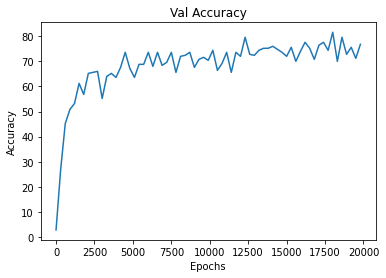

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1,20000,300),acc)
plt.title('Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

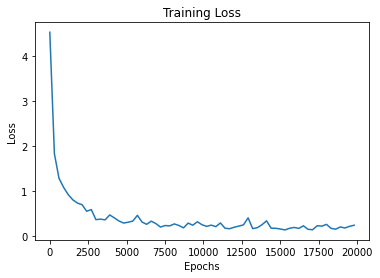

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1,20000,300),losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')